# Banking Dataset - Marketing Targets
##### Jude Darmanin, September 2021


## Abstract

Using a banking dataset consisting of several features describing both the personal and financial attributes of an individual, the scope of this task is to implement an ML solution to predict how likely each individual is to subscribe to a term deposit after a marketing campaign.

After cleaning and transforming the dataset of close to 50,000 individuals, a logistic regression that accurately predicts close to 90% of outcomes was estimated.

## Importing

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")


Pandas threw up a mixed data type warning upon importing data. Using ".value_counts()" for each column it was ascertained that there was a rogue row which contained an exact copy of the column headers somewhere in the middle of the dataset.

Using data.loc[data['age'] == 'age'], the row indexed '4521' was identified as the rogue row. This row is removed when the data is imported.

Due to the "mixed type" issue, pandas initially imported all the columns as "object" types (verified using data.dtypes). The as_type() method was used to convert numerical columns into integer types.

In [2]:
data=pd.read_csv('data.csv', delimiter=';') #reading data

data.drop(labels=[4521], axis=0, inplace=True) #dropping rogue row

#converting numeric columns to proper data type 
data_types={"age": int, 'balance': int, 'duration': int, 'campaign': int, 'pdays': int, 'previous': int, 'day': int}
data = data.astype(data_types)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Checking Data

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#### MISSING VALUES CHECK

The dataset does not contain any missing data.

In [4]:
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### ANALYSING THE CATEGORICAL COLUMNS

The columns 'job','education', 'contact', and 'poutcome' have an 'unkown' component.

'contact' and 'poutcome' have a lot of 'unknown values; hence their usefulness for the analysis is limited.

The amount of 'unknown' jobs is small - these rows can be removed without much loss in observations.

The amount of 'unknown' education is small but not insignificant - removing these rows can result in a loss of information. A classifier will be used later on to predict these 'unkown' values based on the other characteristics.

In [5]:
cat_columns = ['job', 'marital', 'education', 'default','housing', 'loan','contact','month','poutcome','y']

for colc in cat_columns:
    print(f'{colc}: {data[colc].unique()}\n')

#how large is the 'unknown' component?
for colc_ in ['job','education','contact','poutcome']: 
    unk = len(data[data[colc_] == 'unknown'])
    unkpc = (len(data[data[colc_] == 'unknown'])/len(data[colc_]))*100
    print(f'{colc_} % unknown values: {unkpc}')
    


job: ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']

marital: ['married' 'single' 'divorced']

education: ['primary' 'secondary' 'tertiary' 'unknown']

default: ['no' 'yes']

housing: ['no' 'yes']

loan: ['no' 'yes']

contact: ['cellular' 'unknown' 'telephone']

month: ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']

poutcome: ['unknown' 'failure' 'other' 'success']

y: ['no' 'yes']

job % unknown values: 0.655513552642162
education % unknown values: 4.1100297595109785
contact % unknown values: 28.842596316255126
poutcome % unknown values: 81.76626719214993


#### ANALYSING THE NUMERICAL COLUMNS

Each numerical column is checked for outliers (max, min). Unique values are also observed to get an idea of the range of each column.

There appear to be no major issues with the numeric columns and no major outliers.

The 'pdays' column has values of -1 which indicate no previous contact. In order to maintain the ordinal nature of the data, these -1 values will be converted to a large number further below.



In [6]:
num_columns = ['age','balance','campaign','pdays','previous','day']

for coln in num_columns:
    print(f'{coln}: MAX = {data[coln].max()}, MIN = {data[coln].min()}, {data[coln].unique()}\n') 
    


age: MAX = 95, MIN = 18, [30 33 35 59 36 39 41 43 20 31 40 56 37 25 38 42 44 26 55 67 53 68 32 49
 78 23 52 34 61 45 48 57 54 63 51 29 50 27 60 28 21 58 22 46 24 77 75 47
 70 65 64 62 66 19 81 83 80 71 72 69 79 73 86 74 76 87 84 85 90 82 94 95
 18 89 92 93 88]

balance: MAX = 102127, MIN = -8019, [ 1787  4789  1350 ...  9710  8205 14204]

campaign: MAX = 63, MIN = 1, [ 1  4  2  5  3  6 18 10  9  7 12 14 13 24 11  8 29 32 16 22 15 30 25 21
 17 19 23 20 50 28 31 44 43 51 63 41 26 55 38 37 46 27 58 33 35 34 36 39]

pdays: MAX = 871, MIN = -1, [ -1 339 330 176 147 241 152 105 342 101   5  92  56 170 182 297 196 460
 137 367 145 169 207 266 288 168 345 436  90 183 146 335 347 119   7 271
 181  88 141 126  61 373 351 242  62  91 308 250 172 265  78  28  79   1
 188 167  89 164 462 209 321 254  94 364  96 356 149 363 275 325 341 260
 358  87 303  98 327 337 322 102  99 370  84 212  63  81 191 360 332  80
  85 247 150 175 382 261 336  58 206 112 199 133 208 253 135 278 140 298
 273 124 281 162

## Transforming data

In [7]:
original_data = data #making a copy of original dataset before applying transformations

#### BINNING NUMERICAL DATA (FOR ANALYSIS)

Since the dependent variable is binary, numerical columns are grouped into bins for ease of analysis. The original columns will be still used for the model.

Bins are defined either according to quintiles or subjectively defined, depending on the value_counts() and characteristics of the specific variable.

In [8]:
#GROUPING AGE COHORTS
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '65+']
age_bins = [0, 25, 35, 45, 55, 65, 100]
data['age_grp'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)

#BALANCE (QUARTILES)
bal_labels = ['quartile 1', 'quartile 2', 'quartile 3', 'quartile 4', 'quartile 5']
data['bal_qnt'] = pd.qcut(data['balance'], q=5, labels=bal_labels)

#NUMBER OF (CURRENT) CAMPAIGN CONTACTS (SUBJECTIVELY DEFINED BINS)
cmp_labels = ['once', 'twice', '3-6 contacts', '7-10 contacts', '11-20 contacts', '>20 contacts']
cmp_bins = [0, 1, 2, 6, 10, 20, 60] 
#those contacted once have their own bin
data['cmp_grp'] = pd.cut(data['campaign'], bins = cmp_bins, labels=cmp_labels)

#DAYS SINCE LAST CAMPAIGN (SUBJECTIVELY DEFINED BINS)
data.loc[(data['pdays'] == -1),"pdays"] = 1000
#first convert -1 (no previous contact) to 1000 - this helps algorithm better interpret ordinal ranking
pdays_labels = ['≤200 days','201-400 days','>400 days','no previous contact']
pdays_bins = [0, 200, 400, 999, 1000] 
#values of 1000 (no previous campaign) are assigned their own bin
data['pdays_grp'] = pd.cut(data['pdays'], bins=pdays_bins, labels=pdays_labels)

#NUMBER OF PREVIOUS CONTACTS (SUBJECTIVELY DEFINED BINS)
prev_labels = ['no previous contact','≤3 contacts','4-10 contacts','>10 contacts']
prev_bins = [-1, 0.5, 3, 10, 300] #values of 0 (no previous campaign) are assigned their own bin
data['prev_grp'] = pd.cut(data['previous'], bins=prev_bins, labels=prev_labels)

#LABEL DICTIONARY
nlabels_dict = ({'age_grp': {"0-25":0,"26-35":1,"36-45":2,"46-55":3,"56-65":4,"65+":5},
               'bal_qnt': {"quartile 1":0,"quartile 2":1,"quartile 3":2,"quartile 4":3,"quartile 5":4},
               'cmp_grp': {"once":0,"twice":1,"3-6 contacts":2,"7-10 contacts":3,"11-20 contacts":4,">20 contacts":5},
               'pdays_grp': {"≤200 days":0,"201-400 days":1,">400 days":2,"no previous contact":3},
               'prev_grp': {"no previous contact":0,"≤3 contacts":1,"4-10 contacts":2,">10 contacts":3}
               })
data = data.replace(nlabels_dict) #converting bin labels into integers using label dictionary

#### CATEGORISING CATEGORICAL DATA

Variables which are binary or ordinal (such as education) can be label encoded, since algorithm is able to recognise ordinal ranking and gives higher weight to observations with a higher ranking. 

Encoding is done using a dictionary - pandas's automatic encoding feature is not used to ensure that rankings are in correct order.


In [9]:
data['quarter'] = data['month'] #creating new column to convert months in quarters (so not to overwrite original data)

#LABEL DICTIONARY
clabels_dict = ({'education': {"primary":0,"secondary":1,"tertiary":2,"unknown":3},
                'default': {"no":0,"yes":1},
                'housing': {"no":0,"yes":1},
                'loan': {"no":0,"yes":1},
                'quarter': {"jan":'Q1',"feb":'Q1',"mar":'Q1',"apr":'Q2',"may":'Q2',"jun":'Q2',"jul":'Q3',"aug":'Q3',"sep":'Q3',"oct":'Q4',"nov":'Q4',"dec":'Q4'},
                'y': {"no":0,"yes":1},              
                }) 

data = data.replace(clabels_dict)

#### OBTAINING DUMMIES FOR NON-ORDINAL CATEGORICAL DATA

Some columns cannot be ranked as the data features are not ordinal (ex - month, education, marital status). In these cases feature dummies are obtained.

Scikitlearn's OneHotEncoder is used (could also have used pd.get_dummies()). This will create a dummy for each feature - hence it is important to remember not to include one of the feature columns in the prediction model - to avoid the dummy variable trap.

In [10]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe_job = pd.DataFrame(ohe.fit_transform(data[["job"]]).toarray(), columns = ohe.get_feature_names(['job']), index = data.index)
ohe_mar = pd.DataFrame(ohe.fit_transform(data[["marital"]]).toarray(), columns = ohe.get_feature_names(['marital']), index = data.index)
ohe_qrt = pd.DataFrame(ohe.fit_transform(data[["quarter"]]).toarray(), columns = ohe.get_feature_names(['quarter']), index = data.index)
#feature dummies are converted into dataframe to enable concatination with original dataframe.
#data.index is specified since one rogue row was deleted from the original dataframe when importing.
#since the dataframes are concatinated to the original below, make sure that the index values of the dataframes match the original.

data = pd.concat([data, ohe_job,ohe_mar, ohe_qrt], axis=1) #concatinating with original dataframe


## Dealing with 'unknown' values



#### DROPPING UNREQUIRED COLUMNS/ROWS

The 'poutcome' and 'contact' columns have too many unknown values to be of use - these are dropped.

The 'job' column has a few rows with an 'unknown' value - the number of such rows is small enough to remove without affecting sample size significantly. These rows are removed. The 'job_unknown' dummy (created above) is also removed.

'Day' column dropped as this does not give much information, especially since we are not given the date of the dataset (so date since last contact of current campaign can't be calculated).

In [11]:
data.drop(data[data['job'] == 'unknown' ].index, inplace = True)
#filtering by 'unknown' job, obtaining row index and dropping rows by index

data.drop(columns=['poutcome','contact','job_unknown','day'], inplace = True)


#### PREDICTING 'UNKNOWN' EDUCATION

The amount of 'unknown' education is small but not insignificant - removing these rows can result in a loss of information. 

Hence, it was decided to predict these 'unknown' education rows using a decision tree classifier, based on other features. 

The features chosen for the model are based on theoretical reasoning - job and age cohort identified as best predictors for education level.

In [12]:
df_edupred = data[data['education'] != 3] 
#use a dataframe without the 'unknown' education rows (label encoded with 3) for training the model.

#TRAINING
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 

edupred_feautures = (['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
                      'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed',
                      'age_grp'])
#note: job_admin. dummy not included to avoid dummy variable trap

X = df_edupred[edupred_feautures] #explanatory variables
y = df_edupred['education'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #80% training

clf = DecisionTreeClassifier() #creating Decision Tree classifer object
clf = clf.fit(X_train,y_train) #training the decision tree classifier

#TESTING AND EVALUATING
from sklearn import metrics #metrics for accuracy calculation

y_pred = clf.predict(X_test) #testing 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 
#comparing actual 'y' from the test data with predicted 'y' from model

Accuracy: 0.7053994316387748


Since model gives a reasonable prediction accuracy it can be used to predict 'unknown' education in original dataframe

In [13]:
X_ = data[edupred_feautures] #original dataset (including 'unkown' education rows)

#PREDICTING AND REPLACING 'UNKOWN' EDUCATION WITH PREDICTED VALUES
edu_pred = pd.DataFrame(clf.predict(X_), index = data.index, columns=['edu_pred'])
#predictions stored in dataframe with 'edu_pred heading'
data = pd.concat([data, edu_pred], axis=1) #concatinating with original dataframe
data['education'] = np.where(data['education'] == 3, data['edu_pred'], data['education']) 
#replacing 'unknown' with predictions
data.drop(columns=['edu_pred'], inplace = True) #don't need predictions column any more

#UPDATING EDUCATION LABELS DICTIONARY (REMOVING 'UNKNOWN')
clabels_dict['education'] = {"primary":0,"secondary":1,"tertiary":2}

## Analysis

Graphical analysis is performed using percentages. Since the number of positive outcomes is small relative to negative outcomes, analysis on positive outcome levels will be difficult due to the relatively small scale. Hence, data is analysed using outcome percentages by feature.

For convenience, analysis of numerical variables is done using the bins created above.

In [14]:
data['y'].value_counts()

0    43637
1     5769
Name: y, dtype: int64

#### CALCULATING OUTCOME PERCENTAGES BY FEATURE

In [15]:
pc = {} #dictionary to store outcome percentages by feature

pc_cols = ['education','job','marital','default','housing','loan','age_grp', 
           'bal_qnt', 'cmp_grp', 'quarter', 'pdays_grp', 'prev_grp'] #variables to analyse


for x in pc_cols:
    pc[x] = data.groupby(["y", x]).agg({"age" : "count"})
    #group by outcome (level 0) and by feature (level 1) using 'count' as the aggregation method
    #here counts of the 'age' column are used, but any column could have been used as counts will be the same
    #workings stored in 'pc' dictionary for use in graphical analysis
    pc[x] = pc[x].groupby(level=1).apply(lambda x: 100*x/x.sum())
    #grouping by 'feature', obtain percentage of 'y' outcome out of feature total
    #ex - % of divorced with positive outcome out of total divorcees
    pc[x].reset_index(inplace=True)
    #groupby sets grouping columns as index - use reset_index to revert back to numeric (serial) index
 



#### GRAPHICAL ANALYSIS

Analysis suggests that persons more likely to subscribe are students and retired persons (youngest and oldest cohorts), those with a higher education level, and those with adequate finances (no loans, no credit in default, higher balance). 

Persons contacted in the previous campaign are more likely to subscribe, though having more contacts in this campaign reduces the likelihood of subscription. This could suggest that persons generally make up their minds early on in the campaign, and having multiple contacts does not change their mind. Interestingly, persons with whom the last contact in the current campaign was during the winter months (Q1, Q4) were more likely to subscribe.

Marital status doesn't seem to have a significant impact on subscriptions.

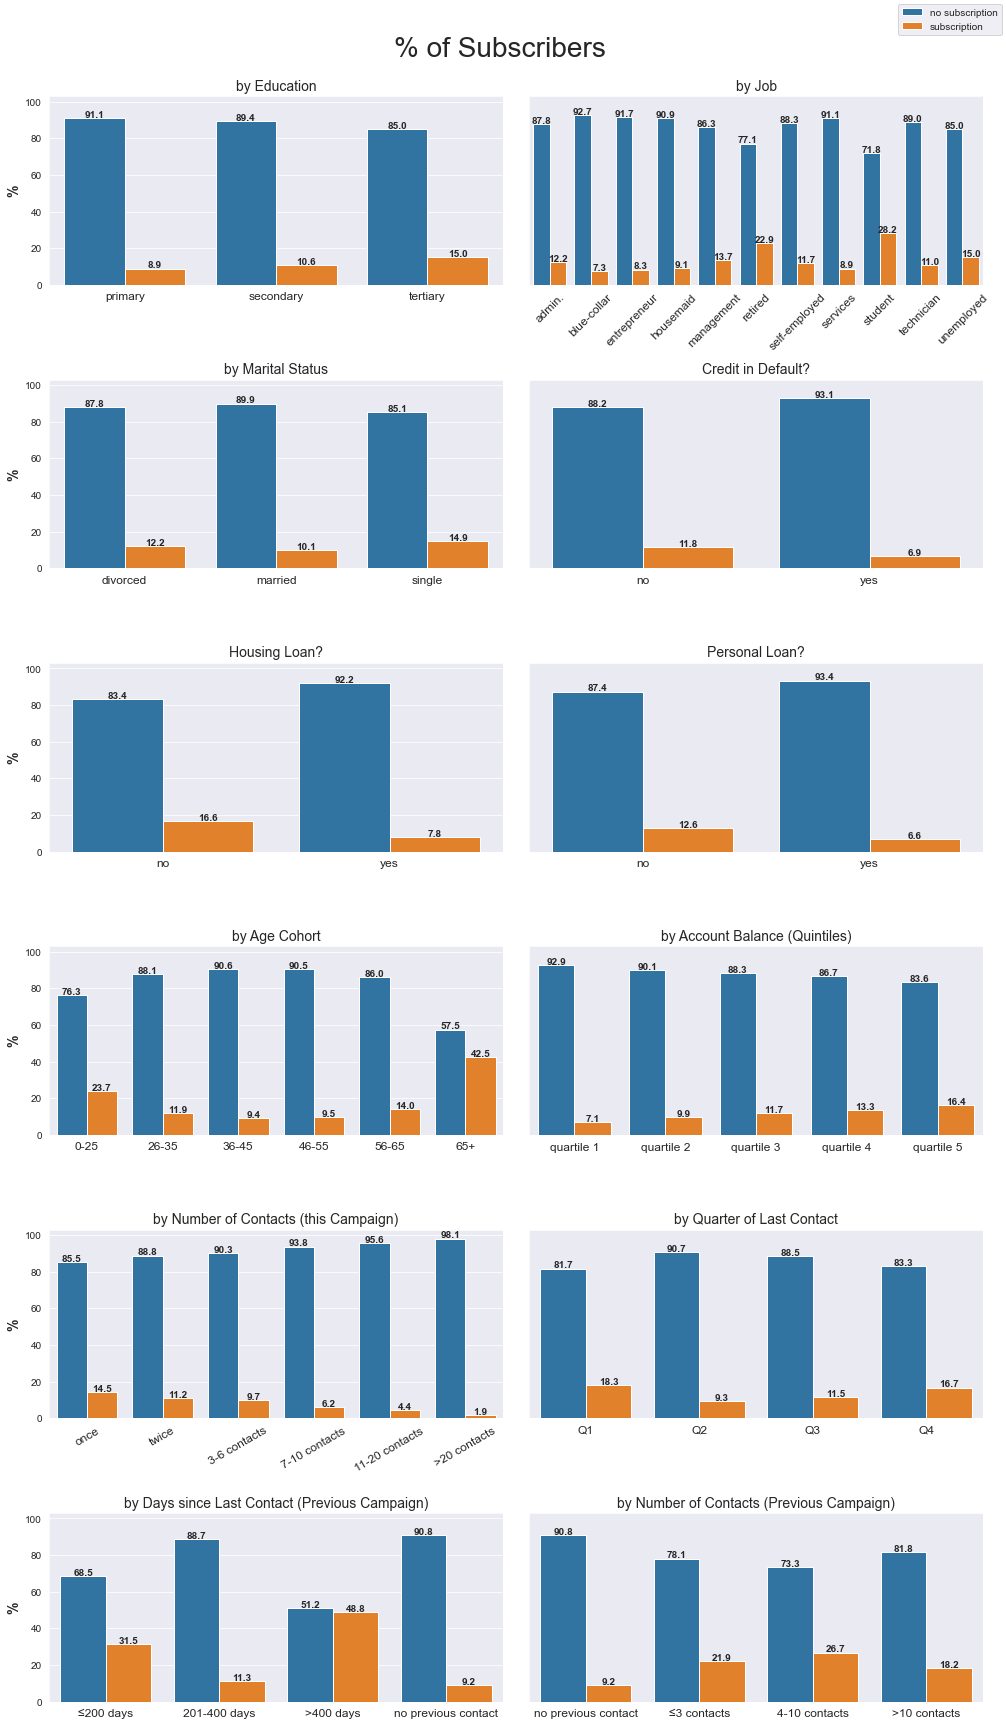

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(14, 24), sharey=True) #graphs share y-axis
fig.suptitle('% of Subscribers\n', fontsize=28)

#EDUCATION
sns.barplot(ax = ax[0,0], x="education", y='age', data=pc['education'], hue = "y")
#groupby counts are aggregated using 'age' column (from above), so this is used as the y-axis
#data is percentage workings calculated above
#bars are coloured (hue) according to outcome ('y')
ax[0,0].set_title("by Education",fontsize=14)
ax[0,0].set_xticklabels(clabels_dict['education'].keys())
#xticklabels are obtained from labels dictionary created above

#JOB
sns.barplot(ax = ax[0,1], x="job", y='age', data=pc['job'], hue = "y")
ax[0,1].set_title("by Job",fontsize=14)
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(),rotation = 45)
ax[0,1].yaxis.set_visible(False) #remove yaxis label from graphs in second column

#MARITAL STATUS
sns.barplot(ax = ax[1,0], x="marital", y='age', data=pc['marital'], hue = "y")
ax[1,0].set_title("by Marital Status",fontsize=14)

#CREDIT IN DEFAULT
sns.barplot(ax = ax[1,1], x="default", y='age', data=pc['default'], hue = "y")
ax[1,1].set_title("Credit in Default?",fontsize=14)
ax[1,1].yaxis.set_visible(False)
ax[1,1].set_xticklabels(clabels_dict['default'].keys())

#HOUSING LOAN
sns.barplot(ax = ax[2,0], x="housing", y='age', data=pc['housing'], hue = "y")
ax[2,0].set_title("Housing Loan?",fontsize=14)
ax[2,0].set_xticklabels(clabels_dict['housing'].keys())

#PERSONAL LOAN
sns.barplot(ax = ax[2,1], x="loan", y='age', data=pc['loan'], hue = "y")
ax[2,1].set_title("Personal Loan?",fontsize=14)
ax[2,1].yaxis.set_visible(False)
ax[2,1].set_xticklabels(clabels_dict['loan'].keys())

#AGE COHORT
sns.barplot(ax = ax[3,0], x="age_grp", y='age', data=pc['age_grp'], hue = "y")
ax[3,0].set_title("by Age Cohort",fontsize=14)
ax[3,0].set_xticklabels(nlabels_dict['age_grp'].keys())

#BALANCE
sns.barplot(ax = ax[3,1], x="bal_qnt", y='age', data=pc['bal_qnt'], hue = "y")
ax[3,1].set_title("by Account Balance (Quintiles)",fontsize=14)
ax[3,1].yaxis.set_visible(False)
ax[3,1].set_xticklabels(nlabels_dict['bal_qnt'].keys())

#CAMPAIGN CONTACTS (CURRENT)
sns.barplot(ax = ax[4,0], x="cmp_grp", y='age', data=pc['cmp_grp'], hue = "y")
ax[4,0].set_title("by Number of Contacts (this Campaign)",fontsize=14)
ax[4,0].set_xticklabels(nlabels_dict['cmp_grp'].keys(),rotation = 30)

#QUARTER OF LAST CONTACT
sns.barplot(ax = ax[4,1], x="quarter", y='age', data=pc['quarter'], hue = "y")
ax[4,1].set_title("by Quarter of Last Contact",fontsize=14)
ax[4,1].yaxis.set_visible(False)

#DAYS FROM PREVIOUS CAMPAIGN CONTACT
sns.barplot(ax = ax[5,0], x="pdays_grp", y='age', data=pc['pdays_grp'], hue = "y")
ax[5,0].set_title("by Days since Last Contact (Previous Campaign)",fontsize=14)
ax[5,0].set_xticklabels(nlabels_dict['pdays_grp'].keys())

#PREVIOUS CONTACTS
sns.barplot(ax = ax[5,1], x="prev_grp", y='age', data=pc['prev_grp'], hue = "y")
ax[5,1].set_title("by Number of Contacts (Previous Campaign)",fontsize=14)
ax[5,1].yaxis.set_visible(False)
ax[5,1].set_xticklabels(nlabels_dict['prev_grp'].keys())

#using the legend of the last figure as the common legend (since all legends are the same)
colours, labels = fig.axes[-1].get_legend_handles_labels()
leg_labels = ['no subscription','subscription']
fig.legend(colours, leg_labels, loc = 'upper right')

for ax in fig.get_axes():
    ax.set_ylabel(ylabel='%', weight='bold', fontsize=14)
    ax.set(xlabel='')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.get_legend().remove()
    
    #ADDING BAR LABELS
    for p in ax.patches: #where p = each rectangle (bar) in the figure
        data_label = format(p.get_height(), ".1f") #label value is value on y axis (to 1 dp)
        x = p.get_x() + p.get_width()/2 #x position is centre of bar
        y = p.get_height() + 1.75 #y position is height of bar plus arbitrary number (to allow space)
        ax.annotate(data_label, (x, y), ha='center', va='center', weight='bold')
        #adding bar label in specified x and y positions


fig.tight_layout()


## Predictions

#### MULTICOLLINEARITY CHECK

A correlation matrix and heatmap are used to check for correlation between variables.

Some expected high correlations between job, education, and age, but not significant.

Dependent variable ('y') correlated with 'duration' - this was stated in the dataset info. There appears to be no other high correlation between the dependent and the explanatory variables.

It appears that there is high collinearity between 'pdays' and 'previous' - probably because clients with no previous contact also had a '-1' (1000) in the 'pdays column.

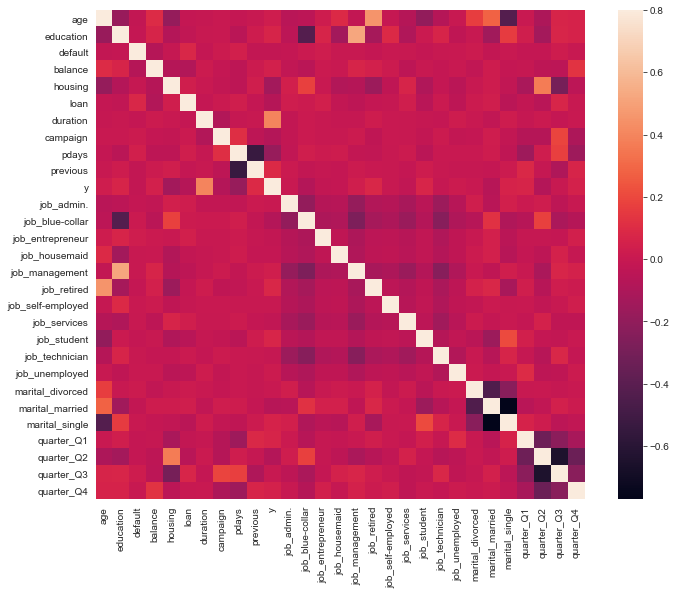

In [17]:
data_corr = data.drop(columns=['age_grp','bal_qnt','cmp_grp','prev_grp','pdays_grp'])
#removing bin columns as these will be naturally be highly correlated with their original columns 

corrmat = data_corr.corr()

#CREATING HEATMAP OF CORRELATIONS
f, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(corrmat, vmax=.8, square=True); 


#### CLEANING DATASET

'Duration' column dropped due to collinearity with dependent variable. 'pdays' also dropped due to correlation with 'prev'.

Some columns can be dropped as they are represented by dummies ('month','job','marital')

Analysis columns (bins) can be dropped.

One dummy variable for each feature is dropped to avoid dummy variable trap.

In [18]:
data_ml = data #creating new dataset to be used for model
data_ml.drop(columns = ['duration','pdays'], inplace=True) #not to be used (multicollinearity)
data_ml.drop(columns = ['month', 'quarter', 'job','marital'], inplace=True) #represented by dummy columns
data_ml.drop(columns = ['job_admin.', 'marital_single', 'quarter_Q1'], inplace=True) #to avoid dummy variable trap
data_ml.drop(columns = ['age_grp', 'bal_qnt', 'cmp_grp', 'pdays_grp', 'prev_grp'], inplace=True)
#analytical columns

print(f'Feautures to be used:\n\n{data_ml.columns}')

Feautures to be used:

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'campaign',
       'previous', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4'],
      dtype='object')


#### MODEL PREP

In [19]:
#SEPARATING DEPENDENT AND EXPLANATORY VARIABLES
y = data_ml['y']

data_ml.drop(columns = ['y'],inplace = True)
features = [] #list of explanatory variables
for z in data_ml.columns:
    features.append(z)

#SCALING DATA AND SETTING AS X VARIABLE MATRIX
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_ml)
X = pd.DataFrame(data_scaled,columns=[features]) #dataframe of scaled X variables


#### MODEL

A logistic regression is used to predict 'y' based on chosen features.

The accuracy of the model is 89%, which is quite good. The bank is able to predict with almost 90% certainty whether a customer will subscribe or not, based on the chosen features.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 20)

#TRAINING
lr_model = LogisticRegression(max_iter=125)
lr_model.fit(X_train,y_train)

#TESTING AND EVALUATING
y_pred = lr_model.predict(X_test) #using model to predict y in test dataset

from sklearn.metrics import classification_report
print(f'Model Metrics:\n\n {classification_report(y_test, y_pred)}')
print(f"Model Accuracy:   {metrics.accuracy_score(y_test, y_pred)}")

Model Metrics:

               precision    recall  f1-score   support

           0       0.89      1.00      0.94      8745
           1       0.67      0.00      0.00      1137

    accuracy                           0.89      9882
   macro avg       0.78      0.50      0.47      9882
weighted avg       0.86      0.89      0.83      9882

Model Accuracy:   0.885043513458814


### Links

https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets - DATASET SOURCE